In [25]:
#one level up into project folder
import os
os.chdir("..")

#print("Current working directory:", os.getcwd())

In [19]:
#import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

from visioninfantnet.constant import training_pipeline


In [3]:
# Locate latest artifact directory
artifact_root = training_pipeline.ARTIFACT_DIR

# Find most recent timestamp folder inside "artifacts/"
timestamps = sorted(os.listdir(artifact_root))
latest_run = timestamps[-1]

print("Latest pipeline run:", latest_run)

run_path = os.path.join(artifact_root, latest_run, training_pipeline.DATA_INGESTION_DIR_NAME)
run_path


Latest pipeline run: 12_01_2025_13_57_06


'artifacts/12_01_2025_13_57_06/data_ingestion'

In [4]:
# Load ingested metadata CSV files
train_csv = os.path.join(run_path, "ingested_metadata", training_pipeline.DATA_INGESTION_TRAIN_METADATA_FILE)
valid_csv = os.path.join(run_path, "ingested_metadata", training_pipeline.DATA_INGESTION_VALID_METADATA_FILE)
test_csv  = os.path.join(run_path, "ingested_metadata", training_pipeline.DATA_INGESTION_TEST_METADATA_FILE)

df_train = pd.read_csv(train_csv)
df_valid = pd.read_csv(valid_csv)
df_test  = pd.read_csv(test_csv)

df_train.head()


,child_ID,age_mo_round,child_gender,clip_ID,Answer,corpus,path
0,2,32,F,0959508684.wav,Crying,Tsimane,artifacts/12_01_2025_13_57_06/data_ingestion/i...
1,37,24,F,0390676632.wav,Crying,Tsimane,artifacts/12_01_2025_13_57_06/data_ingestion/i...
2,35,23,M,0561065096.wav,Crying,Tsimane,artifacts/12_01_2025_13_57_06/data_ingestion/i...
3,37,24,F,0582873027.wav,Crying,Tsimane,artifacts/12_01_2025_13_57_06/data_ingestion/i...
4,4,12,NaN,0961745850.wav,Crying,Seedlings,artifacts/12_01_2025_13_57_06/data_ingestion/i...


In [5]:
# Load full metadata CSV
full_metadata_csv = os.path.join(run_path, training_pipeline.DATA_INGESTION_ARTIFACT_FULL_METADATA_FILE)
df_full = pd.read_csv(full_metadata_csv)

df_full.head()


,child_ID,age_mo_round,child_gender,clip_ID,Answer,corpus,path
0,10,30,M,0874423489.wav,Non-canonical,Tsimane,data/audio/raw/0874423489.wav
1,10,30,M,0492128795.wav,Junk,Tsimane,data/audio/raw/0492128795.wav
2,10,30,M,0580271970.wav,Crying,Tsimane,data/audio/raw/0580271970.wav
3,10,30,M,0547869795.wav,Non-canonical,Tsimane,data/audio/raw/0547869795.wav
4,10,30,M,0587354499.wav,Junk,Tsimane,data/audio/raw/0587354499.wav


## SECTION 1: Metadata EDA

In [6]:
# Print shapes of datasets
print("Full metadata:", df_full.shape)
print("Train:", df_train.shape)
print("Validation:", df_valid.shape)
print("Test:", df_test.shape)


Full metadata: (13478, 7)
Train: (3600, 7)
Validation: (3580, 7)
Test: (3590, 7)


In [7]:
# Check for missing values in full metadata
df_full.isna().sum()


child_ID          0
age_mo_round      0
child_gender    540
clip_ID           0
Answer            8
corpus            0
path              0
dtype: int64

In [24]:
# Print info of datasets
print("Full metadata:", df_full.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13478 entries, 0 to 13477
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   child_ID      13478 non-null  object
 1   age_mo_round  13478 non-null  int64 
 2   child_gender  12938 non-null  object
 3   clip_ID       13478 non-null  object
 4   Answer        13470 non-null  object
 5   corpus        13478 non-null  object
 6   path          13478 non-null  object
dtypes: int64(1), object(6)
memory usage: 737.2+ KB
Full metadata: None


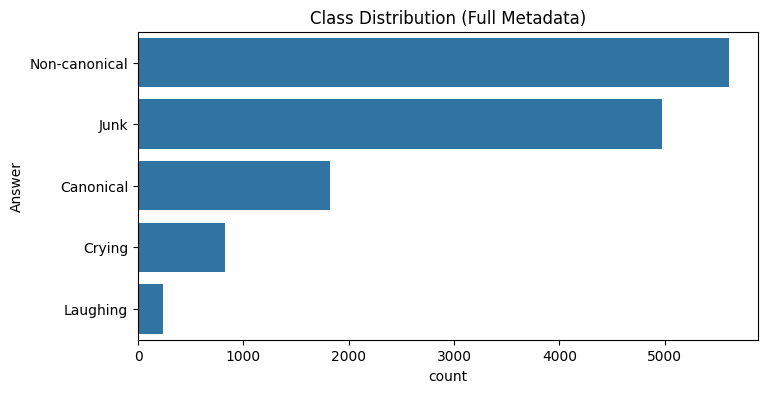

In [8]:
# Visualize class distribution in full metadata
plt.figure(figsize=(8,4))
sns.countplot(y=training_pipeline.TARGET_COLUMN, data=df_full, order=df_full[training_pipeline.TARGET_COLUMN].value_counts().index)
plt.title("Class Distribution (Full Metadata)")
plt.show()


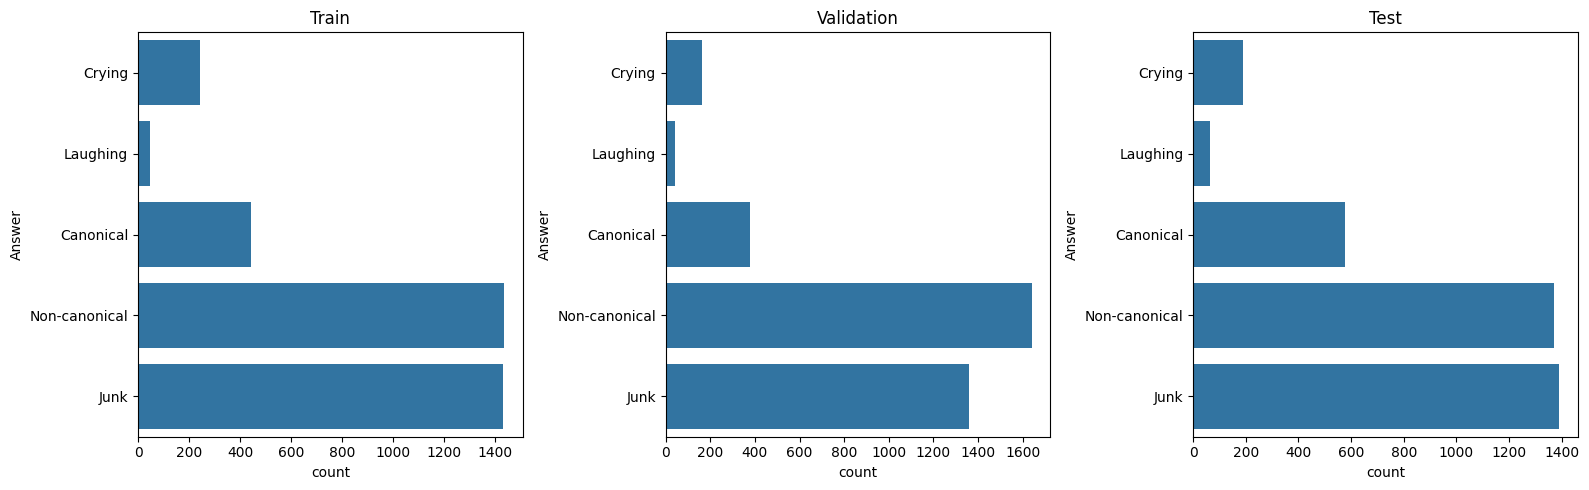

In [9]:
# Visualize class distribution in train, validation, and test sets
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, df, title in zip(
    axes, 
    [df_train, df_valid, df_test],
    ["Train", "Validation", "Test"]
):
    sns.countplot(y=training_pipeline.TARGET_COLUMN, data=df, ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.show()


In [10]:
# Check unique children in each dataset
col = training_pipeline.CHILD_ID_COLUMN
print("Unique children (train):", df_train[col].nunique())
print("Unique children (valid):", df_valid[col].nunique())
print("Unique children (test):", df_test[col].nunique())


Unique children (train): 16
Unique children (valid): 16
Unique children (test): 16


In [11]:
# Check for overlapping children across datasets
train_ids = set(df_train[col])
valid_ids = set(df_valid[col])
test_ids = set(df_test[col])

print("Train ∩ Valid:", train_ids & valid_ids)
print("Train ∩ Test:", train_ids & test_ids)
print("Valid ∩ Test:", valid_ids & test_ids)


Train ∩ Valid: set()
Train ∩ Test: set()
Valid ∩ Test: set()


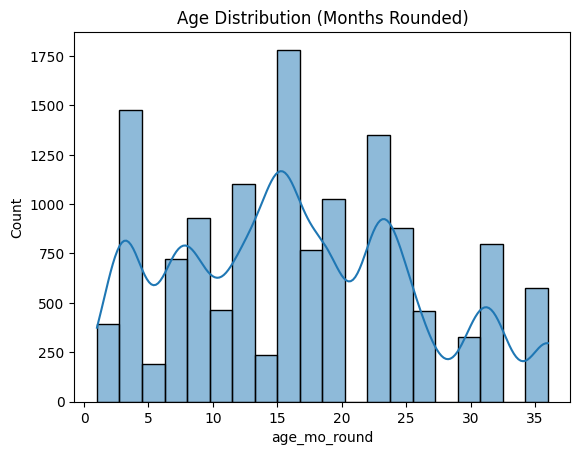

In [12]:
# Visualize age distribution in full metadata
sns.histplot(df_full[training_pipeline.AGE_COLUMN], kde=True, bins=20)
plt.title("Age Distribution (Months Rounded)")
plt.show()

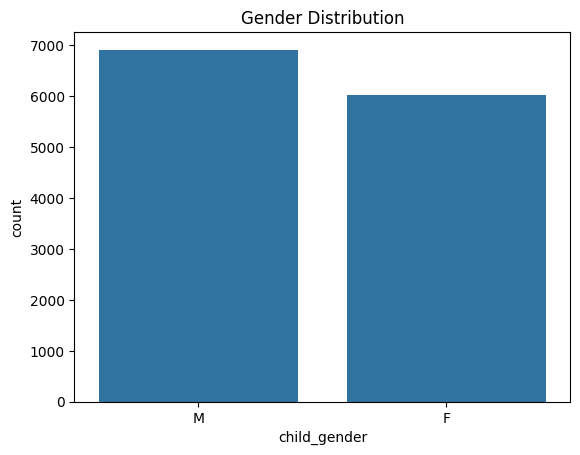

In [13]:
# Visualize gender distribution in full metadata
sns.countplot(x=training_pipeline.GENDER_COLUMN, data=df_full)
plt.title("Gender Distribution")
plt.show()


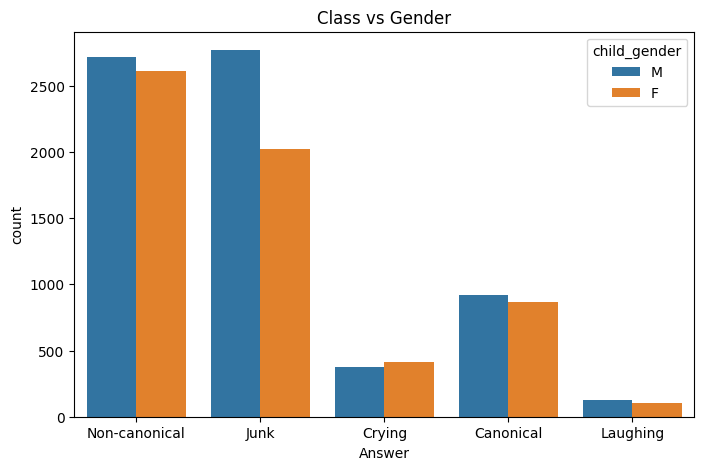

In [15]:
# Visualize Class distribution by gender in full metadata
plt.figure(figsize=(8,5))
sns.countplot(data=df_full, x=training_pipeline.TARGET_COLUMN, hue=training_pipeline.GENDER_COLUMN)
plt.title("Class vs Gender")
plt.show()


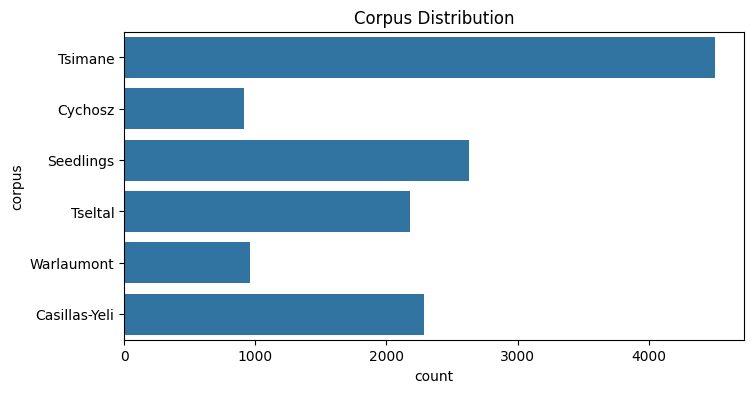

In [16]:
# Visualize corpus distribution in full metadata
plt.figure(figsize=(8,4))
sns.countplot(y=training_pipeline.CORPUS_COLUMN, data=df_full)
plt.title("Corpus Distribution")
plt.show()


## SECTION 2: Audio EDA

In [17]:
# Function to get audio duration
def get_duration(path):
    try:
        audio, sr = librosa.load(path, sr=None)
        return len(audio) / sr
    except:
        return np.nan

In [18]:
# Add duration column to datasets
df_train["duration"] = df_train[training_pipeline.AUDIO_PATH_COLUMN].apply(get_duration)
df_valid["duration"] = df_valid[training_pipeline.AUDIO_PATH_COLUMN].apply(get_duration)
df_test["duration"]  = df_test[training_pipeline.AUDIO_PATH_COLUMN].apply(get_duration)


In [20]:
# Display duration statistics
df_train["duration"].describe(), df_valid["duration"].describe(), df_test["duration"].describe()


(count    3600.000000
 mean        0.357620
 std         0.086035
 min         0.052993
 25%         0.347755
 50%         0.400000
 75%         0.400000
 max         0.500000
 Name: duration, dtype: float64,
 count    3580.000000
 mean        0.352955
 std         0.087845
 min         0.036000
 25%         0.310999
 50%         0.400000
 75%         0.400000
 max         0.500000
 Name: duration, dtype: float64,
 count    3590.000000
 mean        0.359829
 std         0.082807
 min         0.074000
 25%         0.360000
 50%         0.400000
 75%         0.400000
 max         0.500000
 Name: duration, dtype: float64)

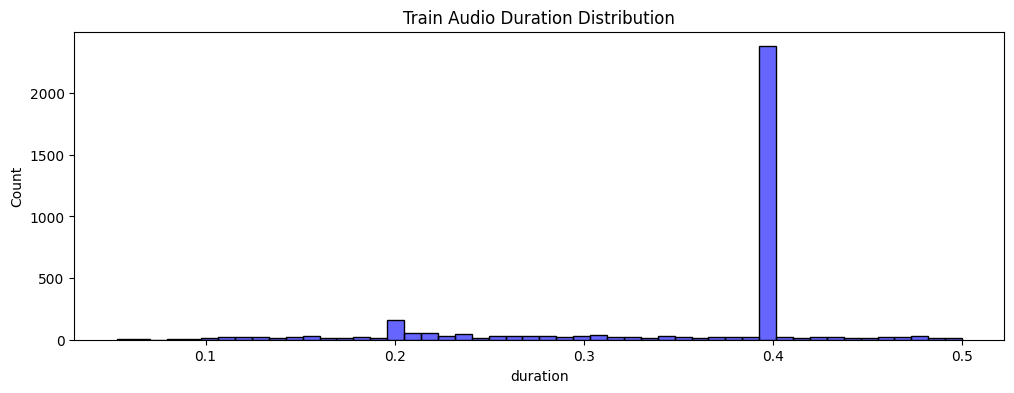

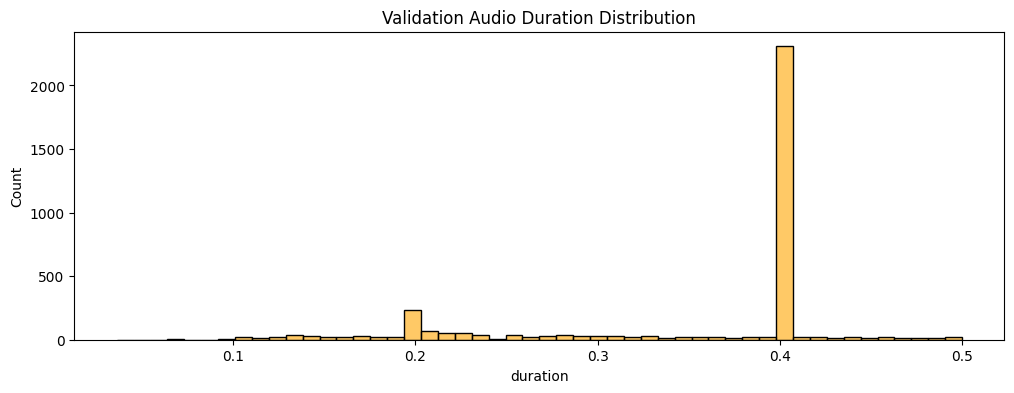

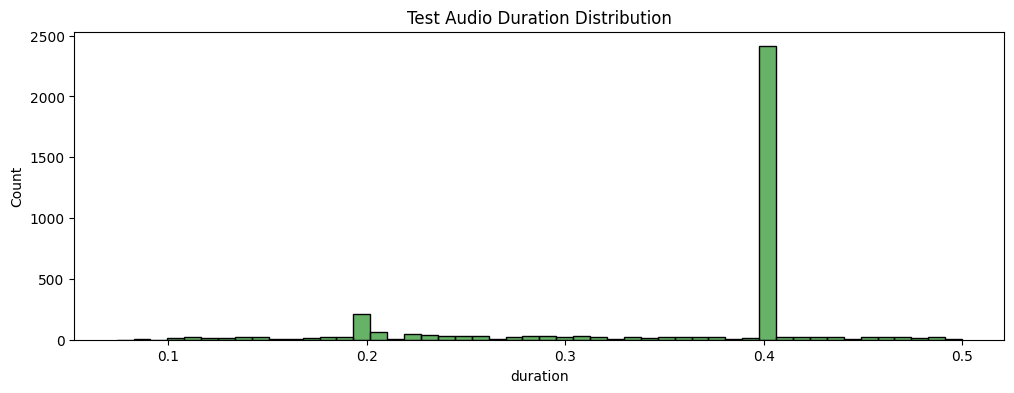

In [21]:
# Visualize duration distribution in train, validation, and test sets
plt.figure(figsize=(12,4))
sns.histplot(df_train["duration"], bins=50, color="blue", alpha=0.6)
plt.title("Train Audio Duration Distribution")
plt.show()

plt.figure(figsize=(12,4))
sns.histplot(df_valid["duration"], bins=50, color="orange", alpha=0.6)
plt.title("Validation Audio Duration Distribution")
plt.show()

plt.figure(figsize=(12,4))
sns.histplot(df_test["duration"], bins=50, color="green", alpha=0.6)
plt.title("Test Audio Duration Distribution")
plt.show()


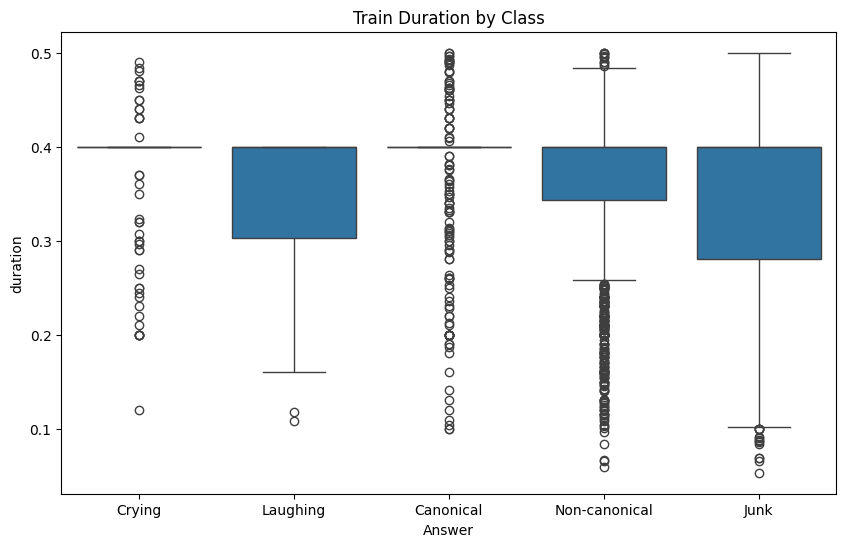

In [22]:
# Visualize duration by class in training set
plt.figure(figsize=(10,6))
sns.boxplot(data=df_train, x=training_pipeline.TARGET_COLUMN, y="duration")
plt.title("Train Duration by Class")
plt.show()


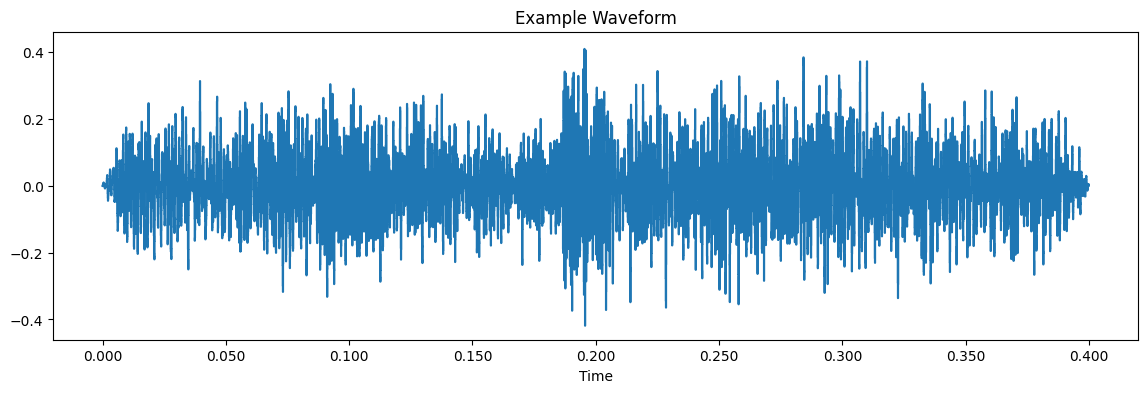

In [23]:
# Visualize an example waveform from training set
example_path = df_train[training_pipeline.AUDIO_PATH_COLUMN].iloc[0]
y, sr = librosa.load(example_path, sr=None)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y, sr=sr)
plt.title("Example Waveform")
plt.show()
